In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt
import os
from torchvision.io import read_image
import numpy as np
import cv2 as cv
from PIL import Image

In [2]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [3]:
train_dataset = ImageFolder('../Datasets/MVTec/bottle/train', transform=transform)
test_dataset = ImageFolder('../Datasets/MVTec/bottle/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# Autoencoder 모델 정의
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # [B, 64, 256, 256]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=0),   # [B, 64, 128, 128]
            nn.Conv2d(64, 128, 3, padding=1), # [B, 128, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=0),   # [B, 128, 64, 64]
            nn.Conv2d(128, 256, 3, padding=1),# [B, 256, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, padding=0)    # [B, 256, 32, 32]
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1),# [B, 256, 32, 32]
            nn.ReLU(),
            nn.Upsample(scale_factor=2),     # [B, 256, 64, 64]
            nn.Conv2d(256, 128, 3, padding=1),# [B, 128, 64, 64]
            nn.ReLU(),
            nn.Upsample(scale_factor=2),     # [B, 128, 128, 128]
            nn.Conv2d(128, 64, 3, padding=1), # [B, 64, 128, 128]
            nn.ReLU(),
            nn.Upsample(scale_factor=2),     # [B, 64, 256, 256]
            nn.Conv2d(64, 3, 3, padding=1),  # [B, 3, 256, 256]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
num_epochs = 80
for epoch in range(num_epochs):
    for data in train_loader:
        imgs, _ = data
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/80], Loss: 0.1275
Epoch [2/80], Loss: 0.1066
Epoch [3/80], Loss: 0.0750
Epoch [4/80], Loss: 0.0371
Epoch [5/80], Loss: 0.0147
Epoch [6/80], Loss: 0.0141
Epoch [7/80], Loss: 0.0104
Epoch [8/80], Loss: 0.0085
Epoch [9/80], Loss: 0.0076
Epoch [10/80], Loss: 0.0070
Epoch [11/80], Loss: 0.0062
Epoch [12/80], Loss: 0.0052
Epoch [13/80], Loss: 0.0048
Epoch [14/80], Loss: 0.0040
Epoch [15/80], Loss: 0.0035
Epoch [16/80], Loss: 0.0028
Epoch [17/80], Loss: 0.0024
Epoch [18/80], Loss: 0.0026
Epoch [19/80], Loss: 0.0024
Epoch [20/80], Loss: 0.0023
Epoch [21/80], Loss: 0.0021
Epoch [22/80], Loss: 0.0022
Epoch [23/80], Loss: 0.0022
Epoch [24/80], Loss: 0.0021
Epoch [25/80], Loss: 0.0021
Epoch [26/80], Loss: 0.0021
Epoch [27/80], Loss: 0.0022
Epoch [28/80], Loss: 0.0020
Epoch [29/80], Loss: 0.0020
Epoch [30/80], Loss: 0.0020
Epoch [31/80], Loss: 0.0020
Epoch [32/80], Loss: 0.0020
Epoch [33/80], Loss: 0.0021
Epoch [34/80], Loss: 0.0020
Epoch [35/80], Loss: 0.0020
Epoch [36/80], Loss: 0.0020
E

In [11]:
def visualize_reconstruction_and_difference(idx, category='broken_large', threshold=0.15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((256, 256))
    ])

    # 이미지 로드
    img_path = f'../Datasets/MVTec/bottle/test/{category}/{idx:03d}.png'
    image = read_image(img_path).float() / 255
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    
    # 복원 이미지 생성
    with torch.no_grad():
        output = model(image)
    
    # 원본, 복원 이미지, 차이 계산
    output_image = output.squeeze(0).cpu()
    diff = torch.abs(image.cpu() - output_image)
    
    diff = diff.mean(dim=1, keepdim=True)
    # 이진화
    binary_diff = (diff > threshold).float()
    
    print(np.shape(binary_diff))
    
    # Ground Truth 로드 
    mask_path = f'../Datasets/MVTec/bottle/ground_truth/{category}/{idx:03d}_mask.png'
    ground_truth = read_image(mask_path).float() / 255
    ground_truth = transform(ground_truth)

    # 시각화
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    axes[0].imshow(TF.to_pil_image(image.squeeze(0)))
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(TF.to_pil_image(output_image))
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    
    axes[2].imshow(TF.to_pil_image(ground_truth.squeeze(0)), cmap='gray')
    axes[2].set_title('Ground Truth Image')
    axes[2].axis('off')

    axes[3].imshow(TF.to_pil_image(binary_diff.squeeze(0)), cmap='gray')
    axes[3].set_title('Binary Difference Image')
    axes[3].axis('off')

    plt.show()

torch.Size([1, 1, 256, 256])


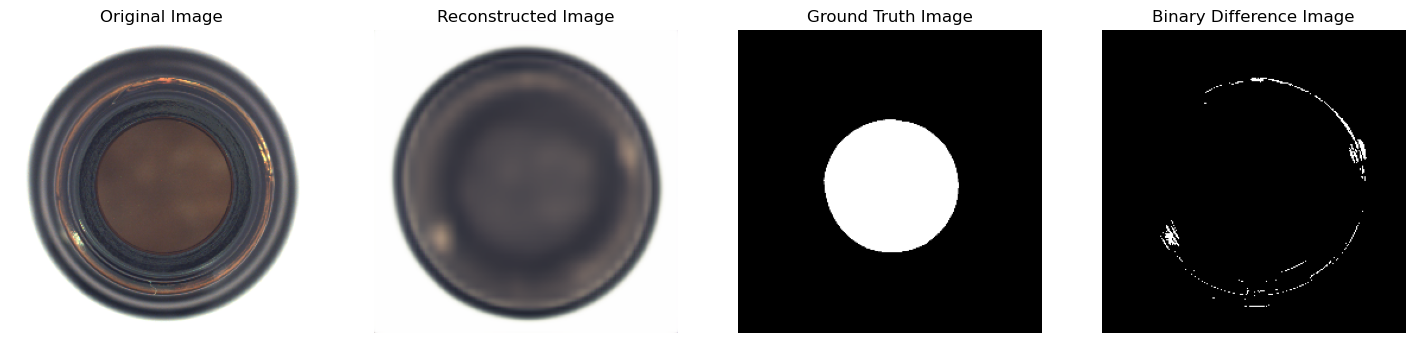

In [29]:
img_idx, category = 0, 'contamination'

visualize_reconstruction_and_difference(img_idx, category=category, threshold=0.15)

In [17]:
def calculate_accuracy(binary_diff, ground_truth):
    
    correct_pixels = torch.sum(binary_diff == ground_truth).item()

    total_pixels = ground_truth.numel()
    accuracy = (correct_pixels / total_pixels) * 100 / 3
    return accuracy


# 모델 성능 평가 함수
def evaluate_model_performance(category='1', threshold=0.1):
    
    accuracies = []
    model.eval()
    
    for idx in range(1, 20):  # 1 to 19
        
        img_path = f'../Datasets/MVTec/bottle/test/{category}/{idx:03d}.png'
        mask_path = f'../Datasets/MVTec/bottle/ground_truth/{category}/{idx:03d}_mask.png'
        
        image = read_image(img_path).float() / 255
        ground_truth = read_image(mask_path).float() / 255

        image = TF.to_pil_image(image)
        image = transform(image).unsqueeze(0).to(device)
        ground_truth = TF.to_pil_image(ground_truth)
        ground_truth = transform(ground_truth).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
        
        output_image = output.squeeze(0).cpu()
        output_image = TF.to_pil_image(output_image)
        output_image = transform(output_image).unsqueeze(0).to(device)
        
        diff = torch.abs(image - output_image)
        binary_diff = (diff > threshold).float()
        
        # 정확도 계산
        binary_diff = binary_diff.to(device)
        ground_truth = ground_truth.to(device)
        accuracy = calculate_accuracy(binary_diff, ground_truth)
        accuracies.append(accuracy)
    
    return accuracies

# 카테고리 1에 대한 성능 평가
accuracies = evaluate_model_performance(category='broken_large', threshold=0.1)

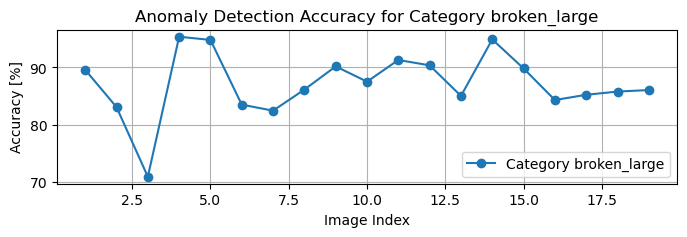

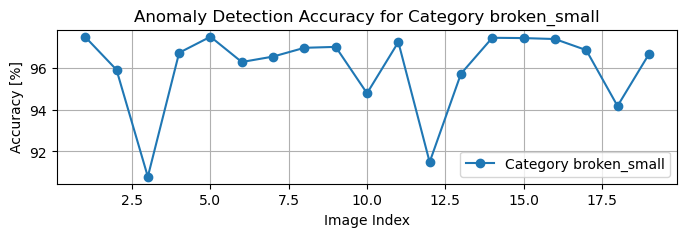

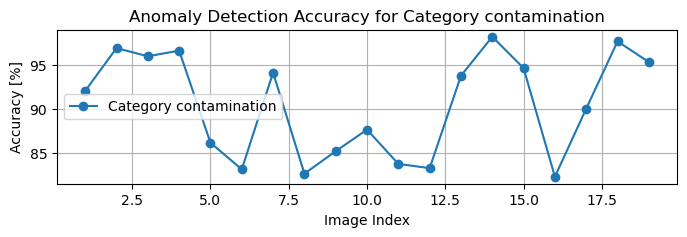

Average accuracy for Category broken_large: 87.18%
Average accuracy for Category broken_small: 96.04%
Average accuracy for Category contamination: 90.49%


In [18]:
# 카테고리별 성능 평가 및 평균 정확도 계산
categories = ['broken_large', 'broken_small', 'contamination']
results = {}
average_accuracies = {}

for category in categories:
    accuracies = evaluate_model_performance(category, threshold=0.15)
    results[category] = accuracies
    average_accuracies[category] = sum(accuracies) / len(accuracies)

# 성능 결과 시각화
for category in categories:
    plt.figure(figsize=(8, 2))
    plt.plot(range(1, 20), results[category], marker='o', label=f'Category {category}')
    plt.xlabel('Image Index')
    plt.ylabel('Accuracy [%]')
    plt.title(f'Anomaly Detection Accuracy for Category {category}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 평균 정확도 출력
for category in categories:
    print(f'Average accuracy for Category {category}: {average_accuracies[category]:.2f}%')

classification 성능

In [20]:
classification_threshold = 0.1
binary_threshold = 0.2

# 흰색 픽셀 비율 계산 함수
def calculate_white_pixel_ratio(binary_diff):
    white_pixels = torch.sum(binary_diff == 1).item()
    total_pixels = 256 * 256
    white_pixel_ratio = (white_pixels / total_pixels) * 100
    return white_pixel_ratio

# 모델 성능 평가 함수
def evaluate_white_pixel_ratio(category, threshold=binary_threshold):
    white_pixel_ratios = []
    model.eval()
    
    for idx in range(20):  # 0 to 19
        img_path = f'../Datasets/MVTec/bottle/test/{category}/{idx:03d}.png'
        
        image = read_image(img_path).float() / 255
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
        
        output_image = output.squeeze(0)
        diff = torch.abs(image - output_image)
        binary_diff = (diff > binary_threshold).float()
        
        # 흰색 픽셀 비율 계산
        binary_diff = binary_diff.to(device)
        white_pixel_ratio = calculate_white_pixel_ratio(binary_diff)
        white_pixel_ratios.append(white_pixel_ratio)
    
    return white_pixel_ratios

# 카테고리별 흰색 픽셀 비율 평가
categories = ['broken_large', 'broken_small', 'contamination', 'good']
white_pixel_results = {}
classification_results = {}
total_images = 20

for category in categories:
    white_pixel_ratios = evaluate_white_pixel_ratio(category, threshold=binary_threshold)
    white_pixel_results[category] = white_pixel_ratios
    
    if category == 'good':
        # 정상 이미지 판별
        correct_classification_count = sum(1 for ratio in white_pixel_ratios if ratio <= classification_threshold)
    else:
        # 비정상 이미지 판별
        correct_classification_count = sum(1 for ratio in white_pixel_ratios if ratio > classification_threshold)
    
    classification_results[category] = correct_classification_count

# 분류 성능 출력
for category in categories:
    classification_accuracy = (classification_results[category] / total_images) * 100
    print(f'Category {category}: Correctly Classified Images = {classification_results[category]}, Classification Accuracy = {classification_accuracy:.2f}%')

# 흰색 픽셀 비율 결과 시각화
for category in categories:
    plt.figure(figsize=(8, 2))
    plt.plot(range(20), white_pixel_results[category], marker='o', label=f'Category {category}')
    plt.axhline(y=classification_threshold, color='r', linestyle='--', label=f'Threshold ({classification_threshold}%)')
    plt.xlabel('Image Index')
    plt.ylabel('White Pixel Ratio [%]')
    plt.title(f'White Pixel Ratio for Category {category}')
    plt.legend()
    plt.grid(True)
    plt.show()

# 평균 흰색 픽셀 비율 출력
for category in categories:
    avg_white_pixel_ratio = sum(white_pixel_results[category]) / len(white_pixel_results[category])
    print(f'Average white pixel ratio for Category {category}: {avg_white_pixel_ratio:.2f}%')


RuntimeError: The size of tensor a (900) must match the size of tensor b (896) at non-singleton dimension 3